In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from operator import itemgetter
import xgboost as xgb
import random
import time
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import average_precision_score
import matplotlib.pyplot as plt
from numpy import genfromtxt
import seaborn as sns
from sklearn import preprocessing
from sklearn.metrics import roc_curve, auc,recall_score,precision_score
import datetime as dt
import os
from tqdm import tqdm_notebook as tqdm
from scipy import stats
import gc
from sklearn.externals import joblib

/usr/local/envs/py3env/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
def signaltonoise(a, axis, ddof): 
    a = np.asanyarray(a) 
    m = a.mean(axis) 
    sd = a.std(axis = axis, ddof = ddof) 
    return np.where(sd == 0, 0, m / sd)

In [3]:
def read_multiple_csv(path):
    files = os.listdir(path)
    df = None
    pbar = tqdm(total=len(files))
    for f in files:
        ext = f.split(".")
        if len(ext)>0 and ext[-1] == "csv":
            #print(f)
            _ = pd.read_csv(os.path.join(path, f))
            if df is None:
                df = _
            else:
                df = df.append(_)
        pbar.update(1)
    del _
    gc.collect()
    return df

In [4]:
def create_feature_map(features):
    outfile = open('xgb.fmap', 'w')
    for i, feat in enumerate(features):
        outfile.write('{0}\t{1}\tq\n'.format(i, feat))
    outfile.close()

In [5]:
def get_importance(gbm, features):
    create_feature_map(features)
    importance = gbm.get_fscore(fmap='xgb.fmap')
    importance = sorted(importance.items(), key=itemgetter(1), reverse=True)
    return importance

In [6]:
def get_features(train, test):
    trainval = list(train.columns.values)
    output = trainval
    return sorted(output)

In [7]:
def run_single(X_train, X_test, y_train, y_test, random_state=0):
    eta = 0.05
    max_depth= 5 
    subsample = 0.7
    colsample_bytree = 0.70 
    min_chil_weight=1
    start_time = time.time()
    features = X_train.columns
    print('XGBoost params. ETA: {}, MAX_DEPTH: {}, SUBSAMPLE: {}, COLSAMPLE_BY_TREE: {}'.format(eta, max_depth, subsample, colsample_bytree))
    params = {
        "objective": "binary:logistic",
        "booster" : "gbtree",
        "eval_metric": "auc",
        "eta": eta,
        "tree_method": 'exact',
        "max_depth": max_depth,
        "subsample": subsample,
        "colsample_bytree": colsample_bytree,
        "silent": 1,
        "min_chil_weight":min_chil_weight,
        "seed": random_state,
        "learning_rate":0.01,
        "n_estimators":1000, 
        "reg_alpha":0.3,
        "gamma":10
    }
    num_boost_round = 500
    early_stopping_rounds = 100
    test_size = 0.1
    
    X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=test_size, random_state=random_state)
    print('Length train:', len(X_train.index))
    print('Length valid:', len(X_valid.index))
    dtrain = xgb.DMatrix(X_train, y_train, missing=-99)
    dvalid = xgb.DMatrix(X_valid, y_valid, missing =-99)

    watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
    gbm = xgb.train(params, dtrain, num_boost_round, evals=watchlist, early_stopping_rounds=early_stopping_rounds, verbose_eval=True)

    print("Validating...")
    check = gbm.predict(xgb.DMatrix(X_valid), ntree_limit=gbm.best_iteration+1)
    
    #area under the precision-recall curve
    score = average_precision_score(y_valid, check)
    print('area under the precision-recall curve: {:.6f}'.format(score))

    
    check2=check.round()
    score = precision_score(y_valid, check2)
    print('precision score: {:.6f}'.format(score))

    score = recall_score(y_valid, check2)
    print('recall score: {:.6f}'.format(score))
    
    imp = get_importance(gbm, features)
    print('Importance array: ', np.array(imp))

    print("Predict test set... ")
    test_prediction = gbm.predict(xgb.DMatrix(X_test,missing = -99), ntree_limit=gbm.best_iteration+1)
    score = average_precision_score(y_test, test_prediction)

    print('area under the precision-recall curve test set: {:.6f}'.format(score))
    
    ############################################ ROC Curve
    

 
    # Compute micro-average ROC curve and ROC area
    fpr, tpr, _ = roc_curve(y_valid, check)
    roc_auc = auc(fpr, tpr)
    #xgb.plot_importance(gbm)
    #plt.show()
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([-0.02, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve')
    plt.legend(loc="lower right")
    plt.show()
    ##################################################
    
    print('Training time: {} minutes'.format(round((time.time() - start_time)/60, 2)))
    # gbm.best_iteration+1
    return test_prediction, imp, gbm


In [8]:
%%time
path = "safety/features/"
feature_df = read_multiple_csv(path)

CPU times: user 36.4 s, sys: 6.13 s, total: 42.5 s
Wall time: 42.5 s


In [9]:
path = "safety/labels/"
label_df = read_multiple_csv(path)
label_df.head()

,bookingID,label
0,111669149733,0
1,335007449205,1
2,171798691856,0
3,1520418422900,0
4,798863917116,0


In [10]:
print(len(label_df))
# we can't keep both due to label contains both 0 and 1
label_df = label_df.drop_duplicates(subset=['bookingID'], keep=False)
print(len(label_df))

20018
19982


In [11]:
label_df = feature_df.groupby('bookingID',as_index=False)\
.agg({'Accuracy':'count'})\
.sort_values(by='Accuracy', ascending=False)\
.rename(columns={'Accuracy':'count'})\
.merge(label_df, on='bookingID', how='inner')

label_df.head()

,bookingID,count,label
0,438086664371,7561,1
1,1374389534819,4499,1
2,34359738469,4302,1
3,1108101562533,3925,1
4,747324309632,3674,1


In [12]:
len(label_df)

19982

In [13]:
# compute acceleration
feature_df = feature_df.fillna(0)
feature_df['acceleration'] = (feature_df['Speed']-feature_df['Speed'].shift())/\
(feature_df['second']-feature_df['second'].shift())
feature_df = feature_df.fillna(0)

In [14]:
len(feature_df)

16135561

In [15]:
%%time
# 1000 rows = 41.5 seconds
# 10000 rows = 5min 10s
# so 16,135,561 rows  = ~7 days
# the computing time is approx linear to number of rows  so no time to wait for the result
# feature_df.sample(10000).groupby('bookingID').describe()

CPU times: user 0 ns, sys: 3 µs, total: 3 µs
Wall time: 7.63 µs


In [16]:
%%time
funcs = ['min','max','mean','median']
feat_df = feature_df.groupby('bookingID', as_index=False)\
.agg({'Speed':funcs, 'acceleration':funcs,'acceleration_x':funcs, 
      'acceleration_y':funcs, 'acceleration_z':funcs, 'second': 'max'})
feat_df.columns = feat_df.columns.map('|'.join).str.strip('|')

CPU times: user 11.6 s, sys: 842 ms, total: 12.5 s
Wall time: 12.5 s


In [17]:
%%time
# This function has less memory usage but slower due to 1 iteration handle one column only
for i in ['Bearing','acceleration_x', 'acceleration_y', 'acceleration_z','gyro_x', 'gyro_y', 'gyro_z']:
    feature_df['z_'+i] = np.abs(stats.zscore(feature_df[i]))
    feature_df[i+'_g_3'] = feature_df['z_'+i] > 3

    temp_df = feature_df.groupby('bookingID', as_index=False)\
    .agg({i+'_g_3':'sum'})

    feat_df = feat_df.merge(temp_df, on='bookingID', how='left')
    feature_df.drop(columns=[i+'_g_3','z_'+i])
    del temp_df
    gc.collect()

CPU times: user 18.5 s, sys: 22.6 s, total: 41.1 s
Wall time: 41.1 s


In [18]:
# count acceleration >= 2 and >= 3
feature_df['acceleration_ge_2'] = feature_df['acceleration'] >= 2
feature_df['acceleration_ge_3'] = feature_df['acceleration'] >= 3

temp_df = feature_df.groupby('bookingID', as_index=False)\
.agg({'acceleration_ge_2':'sum','acceleration_ge_3':'sum'})

feat_df = feat_df.merge(temp_df, on='bookingID', how='left')
feature_df.drop(columns=['acceleration_ge_2','acceleration_ge_3'])
del temp_df
gc.collect()

56

In [19]:
%%time
# compute signal to noise ratio
for i in ['Bearing','Speed','acceleration','acceleration_x', 'acceleration_y', 'acceleration_z','gyro_x', 'gyro_y', 'gyro_z']:
    temp_df = feature_df.groupby('bookingID').apply(lambda x: signaltonoise(x[i], axis=0, ddof=0))
    temp_df = temp_df.reset_index().rename(columns={0:i+'_snr'})
    temp_df = temp_df.replace([np.inf, -np.inf], -1)
    temp_df = temp_df.fillna(0)
    temp_df[i+'_snr'] = temp_df[i+'_snr'].astype('float64')
    feat_df = feat_df.merge(temp_df, on='bookingID', how='left')
    del temp_df
    gc.collect()

/usr/local/envs/py3env/lib/python3.5/site-packages/ipykernel/__main__.py:5: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/envs/py3env/lib/python3.5/site-packages/ipykernel/__main__.py:5: RuntimeWarning: divide by zero encountered in double_scalars
/usr/local/envs/py3env/lib/python3.5/site-packages/numpy/core/_methods.py:117: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
/usr/local/envs/py3env/lib/python3.5/site-packages/numpy/core/_methods.py:75: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)
/usr/local/envs/py3env/lib/python3.5/site-packages/numpy/core/_methods.py:107: RuntimeWarning: invalid value encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True)


CPU times: user 2min 34s, sys: 15.4 s, total: 2min 49s
Wall time: 2min 49s


In [20]:
feat_df = feat_df.replace([np.inf, -np.inf], -1)
feat_df = feat_df.fillna(0)

In [21]:
feat_df = feat_df.merge(label_df.drop(columns=['count']), on='bookingID', how='inner')

In [22]:
len(feat_df)

19982

In [23]:
feat_df.isnull().values.sum()

0

In [24]:
feat_df.sample(10)

,bookingID,acceleration_x|min,acceleration_x|max,acceleration_x|mean,acceleration_x|median,Speed|min,Speed|max,Speed|mean,Speed|median,second|max,...,Bearing_snr,Speed_snr,acceleration_snr,acceleration_x_snr,acceleration_y_snr,acceleration_z_snr,gyro_x_snr,gyro_y_snr,gyro_z_snr,label
11343,910533066869,-1.449799,3.485107,1.183509,1.196670,0.00,16.170000,5.512803,3.900000,479.0,...,1.586489,1.051042,0.000000,1.608617,17.200617,-1.526459,0.052770,-0.006481,0.612349,0
12169,979252543654,-2.745712,3.490601,0.404248,0.444275,-1.00,20.110000,4.230543,1.970000,224.0,...,0.613680,0.811132,0.119192,0.538263,25.435226,0.224813,-0.061297,0.048945,-0.133064,0
15578,1322849927193,-3.479141,3.043869,0.041749,0.056503,0.00,26.680000,18.173547,21.030000,734.0,...,1.447481,2.539693,0.000000,0.048437,15.132817,0.343748,0.069021,0.033194,-0.010305,0
17324,1460288880702,-2.853000,3.945000,0.529083,0.593000,-1.00,23.931496,9.815664,10.143116,1922.0,...,3.717729,1.259352,0.013636,0.927773,23.449768,1.817571,-0.006528,0.044466,0.008354,0
10528,841813590110,-5.145096,3.088577,-0.276302,-0.269897,0.00,24.030000,9.037317,7.120000,914.0,...,0.828499,1.105725,0.000000,-0.400952,19.619187,1.529386,-0.006609,-0.093661,-0.042419,0
1506,111669149832,-5.643661,4.068436,0.277038,0.480118,0.00,22.490000,10.837301,11.890000,644.0,...,0.953609,1.340479,-0.011153,0.223762,7.503416,-0.475743,0.004072,0.077565,0.009307,0
13259,1090921693252,-8.810662,5.382165,-1.045429,-1.015142,0.00,23.372550,15.964529,17.612103,614.0,...,0.978036,2.816931,-0.038617,-0.818133,7.488906,2.584139,0.161352,-0.131141,0.275733,0
17079,1434519077030,-3.107544,3.261566,-0.073006,-0.069542,-1.00,28.410000,17.225817,19.705000,1259.0,...,2.477216,2.240828,0.000000,-0.103818,9.879665,1.542284,0.030835,-0.049696,0.071093,0
16069,1357209665573,-4.283358,5.286559,0.242552,0.262173,-1.00,20.753191,7.605117,6.847301,1483.0,...,1.959509,1.129872,0.000000,0.276851,22.929408,1.720745,-0.230942,-0.133569,0.271976,0
16607,1391569404004,-2.612695,1.475174,-0.681137,-0.725774,0.18,16.410000,6.652530,5.365000,329.0,...,2.923684,1.492609,0.101034,-1.374180,-9.057790,-0.437416,-0.028429,1.191372,0.108819,0


In [35]:
feat_df.describe()

,bookingID,acceleration_x|min,acceleration_x|max,acceleration_x|mean,acceleration_x|median,Speed|min,Speed|max,Speed|mean,Speed|median,second|max,...,Bearing_snr,Speed_snr,acceleration_snr,acceleration_x_snr,acceleration_y_snr,acceleration_z_snr,gyro_x_snr,gyro_y_snr,gyro_z_snr,label
count,1.998200e+04,19982.000000,19982.000000,19982.000000,19982.000000,19982.000000,19982.000000,19982.000000,19982.000000,1.998200e+04,...,19982.000000,19982.000000,19982.000000,19982.000000,19982.000000,19982.000000,1.998200e+04,1.998200e+04,1.998200e+04,19982.000000
mean,8.161654e+11,-4.114738,4.211715,0.072298,0.078686,-0.229749,20.962369,8.427106,7.909898,1.997500e+05,...,2.350622,1.379657,0.009966,0.105295,7.649226,0.921966,-5.011695e+11,-1.229273e+11,1.310896e+11,0.249374
std,4.944728e+11,2.738993,2.670618,1.002654,1.026300,1.647574,5.315183,4.293325,5.707727,1.373755e+07,...,6.280023,1.117473,0.039491,1.403099,14.017292,3.807031,5.136108e+13,1.737672e+13,5.007862e+13,0.432662
min,0.000000e+00,-78.419685,-7.121210,-9.818555,-9.814133,-2.000000,-1.000000,-1.000000,-1.000000,1.190000e+02,...,0.000000,-5.709528,-0.706916,-21.930769,-100.073500,-45.471953,-6.140832e+15,-2.456333e+15,-3.521398e+15,0.000000
25%,3.865471e+11,-4.661212,2.925846,-0.265036,-0.259750,-1.000000,17.256320,5.259188,3.535163,5.540000e+02,...,1.323344,0.987109,0.000000,-0.323965,-0.268547,-0.726496,-5.591672e-02,-5.977273e-02,-5.823254e-02,0.000000
50%,7.988639e+11,-3.631261,3.710951,0.057824,0.061021,0.000000,21.058208,7.476763,6.549824,8.540000e+02,...,1.762051,1.189159,0.000000,0.070351,12.674634,0.707134,-7.199382e-03,-4.316469e-03,-5.419423e-03,0.000000
75%,1.245541e+12,-2.820456,4.750000,0.392976,0.398966,0.000000,24.902692,10.929455,11.300000,1.217000e+03,...,2.452378,1.457741,0.025466,0.472650,16.693681,2.474057,3.302861e-02,5.030578e-02,4.441973e-02,0.000000
max,1.709397e+12,8.158600,66.873456,10.005866,9.987427,25.296043,148.018630,29.557195,30.468207,1.495797e+09,...,405.819974,33.092427,0.584441,38.572219,224.072356,199.294929,5.752457e+00,1.164161e+01,6.140832e+15,1.000000


In [46]:
feat_df = feat_df.sort_values(by='bookingID')

In [57]:
cols = feat_df.drop(columns=['bookingID','label']).columns

In [78]:
cols

Index(['acceleration_x|min', 'acceleration_x|max', 'acceleration_x|mean',
       'acceleration_x|median', 'Speed|min', 'Speed|max', 'Speed|mean',
       'Speed|median', 'second|max', 'acceleration_z|min',
       'acceleration_z|max', 'acceleration_z|mean', 'acceleration_z|median',
       'acceleration|min', 'acceleration|max', 'acceleration|mean',
       'acceleration|median', 'acceleration_y|min', 'acceleration_y|max',
       'acceleration_y|mean', 'acceleration_y|median', 'Bearing_g_3',
       'acceleration_x_g_3', 'acceleration_y_g_3', 'acceleration_z_g_3',
       'gyro_x_g_3', 'gyro_y_g_3', 'gyro_z_g_3', 'acceleration_ge_2',
       'acceleration_ge_3', 'Bearing_snr', 'Speed_snr', 'acceleration_snr',
       'acceleration_x_snr', 'acceleration_y_snr', 'acceleration_z_snr',
       'gyro_x_snr', 'gyro_y_snr', 'gyro_z_snr'],
      dtype='object')

In [58]:
# take only label 0 and 1
y = feat_df['label'].values

In [59]:
X = feat_df[cols]

In [60]:
# sanity check
print(X.shape)
print(y.shape)

(19982, 39)
(19982,)


In [63]:
# sanity check
rnd = np.random.randint(0,X.shape[0]-1, size=2)
print(rnd)
assert np.array_equal(X.iloc[rnd[0]].values,feat_df.drop(columns=['bookingID','label']).iloc[rnd[0]].values)
assert np.array_equal(y[rnd[1]], feat_df.iloc[rnd[1]]['label'])

[1755 6410]


In [64]:
# split X and y into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [65]:
# inspect class imbalance
pd.DataFrame(y_train, columns=['y'])\
.reset_index()\
.groupby('y', as_index=False)\
.count()\
.rename(columns={'index':'count'})

,y,count
0,0,11993
1,1,3992


In [66]:
# inspect class imbalance
pd.DataFrame(y_test, columns=['y'])\
.reset_index()\
.groupby('y', as_index=False)\
.count()\
.rename(columns={'index':'count'})

,y,count
0,0,3006
1,1,991


Start time:  2019-06-16 15:18:20.785429
XGBoost params. ETA: 0.05, MAX_DEPTH: 5, SUBSAMPLE: 0.7, COLSAMPLE_BY_TREE: 0.7
Length train: 14386
Length valid: 1599
[0]	train-auc:0.707791	eval-auc:0.716564
Multiple eval metrics have been passed: 'eval-auc' will be used for early stopping.

Will train until eval-auc hasn't improved in 100 rounds.
[1]	train-auc:0.719583	eval-auc:0.709103
[2]	train-auc:0.727739	eval-auc:0.724384
[3]	train-auc:0.731077	eval-auc:0.722569
[4]	train-auc:0.733134	eval-auc:0.728385
[5]	train-auc:0.735198	eval-auc:0.735168
[6]	train-auc:0.735118	eval-auc:0.737197
[7]	train-auc:0.735454	eval-auc:0.738717
[8]	train-auc:0.734715	eval-auc:0.73855
[9]	train-auc:0.734548	eval-auc:0.738918
[10]	train-auc:0.734273	eval-auc:0.740354
[11]	train-auc:0.734475	eval-auc:0.740251
[12]	train-auc:0.734448	eval-auc:0.740891
[13]	train-auc:0.735604	eval-auc:0.739261
[14]	train-auc:0.73556	eval-auc:0.739801
[15]	train-auc:0.736182	eval-auc:0.739991
[16]	train-auc:0.736766	eval-auc:0.7396

[187]	train-auc:0.748361	eval-auc:0.745347
[188]	train-auc:0.748446	eval-auc:0.74524
[189]	train-auc:0.748434	eval-auc:0.745384
[190]	train-auc:0.748523	eval-auc:0.745136
[191]	train-auc:0.748613	eval-auc:0.745221
[192]	train-auc:0.748569	eval-auc:0.745206
[193]	train-auc:0.74862	eval-auc:0.74526
[194]	train-auc:0.748661	eval-auc:0.745253
[195]	train-auc:0.748689	eval-auc:0.745561
[196]	train-auc:0.748661	eval-auc:0.745518
[197]	train-auc:0.748706	eval-auc:0.745505
[198]	train-auc:0.748772	eval-auc:0.745581
[199]	train-auc:0.74881	eval-auc:0.745505
[200]	train-auc:0.748747	eval-auc:0.74566
[201]	train-auc:0.748765	eval-auc:0.745569
[202]	train-auc:0.748809	eval-auc:0.745719
[203]	train-auc:0.748884	eval-auc:0.745973
[204]	train-auc:0.748874	eval-auc:0.746035
[205]	train-auc:0.748947	eval-auc:0.746054
[206]	train-auc:0.749047	eval-auc:0.745952
[207]	train-auc:0.749044	eval-auc:0.745975
[208]	train-auc:0.749079	eval-auc:0.74593
[209]	train-auc:0.74905	eval-auc:0.745954
[210]	train-auc:0.

[379]	train-auc:0.755163	eval-auc:0.749108
[380]	train-auc:0.75524	eval-auc:0.749091
[381]	train-auc:0.755328	eval-auc:0.749215
[382]	train-auc:0.755469	eval-auc:0.749183
[383]	train-auc:0.755497	eval-auc:0.74911
[384]	train-auc:0.755563	eval-auc:0.749049
[385]	train-auc:0.755617	eval-auc:0.749164
[386]	train-auc:0.755624	eval-auc:0.749153
[387]	train-auc:0.755665	eval-auc:0.74904
[388]	train-auc:0.755666	eval-auc:0.749057
[389]	train-auc:0.755751	eval-auc:0.749036
[390]	train-auc:0.755772	eval-auc:0.749087
[391]	train-auc:0.755809	eval-auc:0.749061
[392]	train-auc:0.755864	eval-auc:0.749119
[393]	train-auc:0.75592	eval-auc:0.749106
[394]	train-auc:0.755946	eval-auc:0.749164
[395]	train-auc:0.755946	eval-auc:0.749164
[396]	train-auc:0.755968	eval-auc:0.749172
[397]	train-auc:0.756046	eval-auc:0.749157
[398]	train-auc:0.756064	eval-auc:0.749157
[399]	train-auc:0.756109	eval-auc:0.749087
[400]	train-auc:0.756104	eval-auc:0.749106
[401]	train-auc:0.756119	eval-auc:0.7491
[402]	train-auc:0

/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


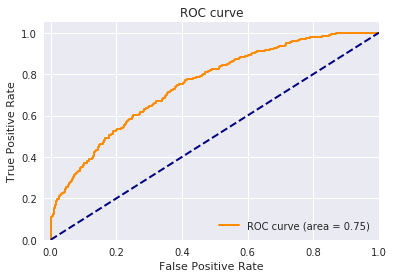

Training time: 1.81 minutes
0:01:48.795359
CPU times: user 12min 18s, sys: 2.27 s, total: 12min 20s
Wall time: 1min 48s


In [67]:
%%time
start_time = dt.datetime.now()
print("Start time: ",start_time)
preds, imp, model = run_single(X_train, X_test, y_train, y_test,2019)
print(dt.datetime.now()-start_time)

In [68]:
y_pred = model.predict(xgb.DMatrix(X), ntree_limit=model.best_iteration+1)
y_pred = (y_pred > 0.5).astype(int)

/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


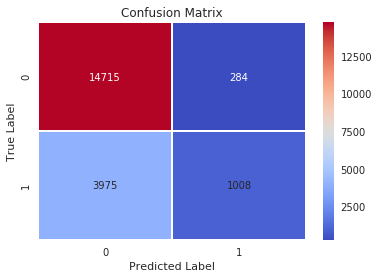

In [69]:
from sklearn import metrics

def plot_confusion_matrix(y, y_hat):
  matrix = metrics.confusion_matrix(y, y_hat)
  plt.figure(figsize=(6, 4))
  sns.heatmap(matrix,
              cmap="coolwarm",
              linecolor='white',
              linewidths=1,
              annot=True,
              fmt="d")
  plt.title("Confusion Matrix")
  plt.ylabel("True Label")
  plt.xlabel("Predicted Label")
  plt.show()
  
plot_confusion_matrix(y, y_pred)

In [70]:
print(metrics.classification_report(y, y_pred))

             precision    recall  f1-score   support

          0       0.79      0.98      0.87     14999
          1       0.78      0.20      0.32      4983

avg / total       0.79      0.79      0.74     19982



In [72]:
# save into file for inspection
label_df['y_pred'] = y_pred
label_df.to_parquet("data/xgboost_feature_eng_ypred.parquet")

In [75]:
label_df.tail()

,bookingID,count,label,y_pred
19977,1374389534748,120,0,1
19978,1228360646706,120,0,0
19979,850403524704,120,0,0
19980,764504178759,120,0,0
19981,721554505843,120,0,0


In [77]:
# save model to file
joblib.dump(model, "models/xgboost_feature_engineered.model")

['models/xgboost_feature_engineered.model']